# MNIST Classification


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import requests
import gzip
import os
from datetime import datetime
import time

# Configuration du style matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configuration PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)  # Pour la reproductibilité
np.random.seed(42)

print("Configuration du système")
print(f"Device utilisé: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Mémoire GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("GPU non disponible, utilisation du CPU")

print("\n" + "="*50)


Configuration du système
Device utilisé: cpu
PyTorch version: 2.7.1+cpu
NumPy version: 2.3.2
GPU non disponible, utilisation du CPU



In [12]:
class MNISTNet(nn.Module):
    """
    Architecture CNN pour la classification MNIST
    
    Structure:
    - Conv2D(1→32) + ReLU + MaxPool2D
    - Conv2D(32→64) + ReLU + MaxPool2D  
    - Conv2D(64→128) + ReLU + MaxPool2D
    - Flatten + FC(1152→512) + ReLU + Dropout(0.5)
    - FC(512→256) + ReLU + Dropout(0.5)
    - FC(256→10) [Sortie - 10 classes]
    """
    
    def __init__(self):
        super(MNISTNet, self).__init__()
        
        # Couches convolutionnelles
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)    # 28x28 → 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # 14x14 → 14x14  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 7x7 → 7x7
        
        # MaxPooling 2x2
        self.pool = nn.MaxPool2d(2, 2)
        
        # Couches fully connected
        # Après 3x MaxPool2D: 28→14→7→3, donc 3x3x128 = 1152
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # 10 classes (chiffres 0-9)
        
        # Dropout pour régularisation
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Bloc convolutionnel 1: Conv → ReLU → MaxPool
        x = self.pool(F.relu(self.conv1(x)))  # (B, 1, 28, 28) → (B, 32, 14, 14)
        
        # Bloc convolutionnel 2
        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 14, 14) → (B, 64, 7, 7)
        
        # Bloc convolutionnel 3  
        x = self.pool(F.relu(self.conv3(x)))  # (B, 64, 7, 7) → (B, 128, 3, 3)
        
        # Aplatir pour les couches FC
        x = x.view(-1, 128 * 3 * 3)  # (B, 128, 3, 3) → (B, 1152)
        
        # Couches fully connected avec dropout
        x = F.relu(self.fc1(x))      # (B, 1152) → (B, 512)
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))      # (B, 512) → (B, 256)  
        x = self.dropout(x)
        
        x = self.fc3(x)              # (B, 256) → (B, 10)
        
        return x
    
    def count_parameters(self):
        """Compte le nombre de paramètres du modèle"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Créer une instance du modèle pour tester
model = MNISTNet().to(device)
print(f"Modèle CNN créé avec {model.count_parameters():,} paramètres")

# Tester avec un exemple d'entrée
example_input = torch.randn(1, 1, 28, 28).to(device)
with torch.no_grad():
    example_output = model(example_input)
    print(f"Test forward pass: {example_input.shape} → {example_output.shape}")
    print(f"Exemple de sortie: {example_output.squeeze()[:5].cpu().numpy()}")  # Premières 5 valeurs


Modèle CNN créé avec 816,906 paramètres
Test forward pass: torch.Size([1, 1, 28, 28]) → torch.Size([1, 10])
Exemple de sortie: [-0.07950926  0.04249244 -0.02781759 -0.02998102 -0.02098837]


In [13]:
def load_mnist_data():
    """
    Charge les données MNIST en utilisant torchvision.datasets.MNIST
    
    Returns:
        tuple: (train_images, train_labels, test_images, test_labels)
    """
    
    from torchvision import datasets, transforms
    
    print("Chargement des données MNIST avec torchvision...")
    
    # Définir les transformations pour normaliser les données
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Charger les datasets d'entraînement et de test
    train_dataset = datasets.MNIST(
        root='data', 
        train=True, 
        download=True, 
        transform=transform
    )
    
    test_dataset = datasets.MNIST(
        root='data', 
        train=False, 
        download=True, 
        transform=transform
    )
    
    # Extraire les images et labels
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    
    # Extraire les données d'entraînement
    for i in range(len(train_dataset)):
        img, label = train_dataset[i]
        # Convertir le tensor normalisé en numpy array pour la visualisation
        # On inverse la normalisation pour avoir les valeurs originales [0, 255]
        img_denorm = (img.squeeze().numpy() * 0.3081 + 0.1307) * 255
        train_images.append(img_denorm.astype(np.uint8))
        train_labels.append(label)
    
    # Extraire les données de test
    for i in range(len(test_dataset)):
        img, label = test_dataset[i]
        img_denorm = (img.squeeze().numpy() * 0.3081 + 0.1307) * 255
        test_images.append(img_denorm.astype(np.uint8))
        test_labels.append(label)
    
    # Convertir en numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    print(f"Dataset chargé:")
    print(f"Training: {train_images.shape[0]:,} images ({train_images.shape[1]}x{train_images.shape[2]})")
    print(f"Test: {test_images.shape[0]:,} images ({test_images.shape[1]}x{test_images.shape[2]})")
    print(f"Classes: {len(np.unique(train_labels))} (chiffres 0-9)")
    
    return train_images, train_labels, test_images, test_labels

# Charger les données
train_images, train_labels, test_images, test_labels = load_mnist_data()


Chargement des données MNIST avec torchvision...
Dataset chargé:
Training: 60,000 images (28x28)
Test: 10,000 images (28x28)
Classes: 10 (chiffres 0-9)


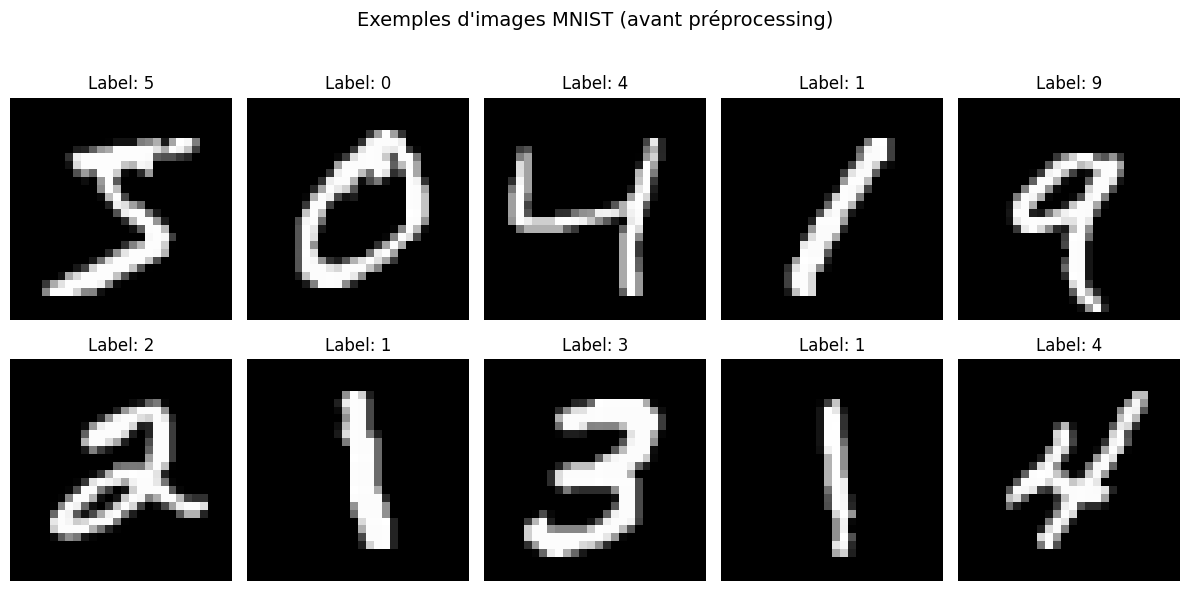

Statistiques des données brutes:
Valeurs pixels: [0, 255]
Moyenne: 33.294
Écart-type: 78.552
Distribution labels: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


In [14]:
# Visualisation de quelques exemples avant préprocessing
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Exemples d\'images MNIST (avant préprocessing)', fontsize=14, y=1.02)

for i in range(10):
    row, col = i // 5, i % 5
    axes[row, col].imshow(train_images[i], cmap='gray')
    axes[row, col].set_title(f'Label: {train_labels[i]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Statistiques des données brutes
print("Statistiques des données brutes:")
print(f"Valeurs pixels: [{train_images.min()}, {train_images.max()}]")
print(f"Moyenne: {train_images.mean():.3f}")
print(f"Écart-type: {train_images.std():.3f}")
print(f"Distribution labels: {np.bincount(train_labels)}")


In [15]:
def export_to_onnx(model, onnx_path='models/mnist_model.onnx'):
    """
    Exporte le modèle PyTorch vers le format ONNX
    
    Args:
        model: Modèle PyTorch entraîné
        onnx_path: Chemin de sauvegarde du modèle ONNX
    
    Returns:
        bool: True si l'export a réussi
    """
    
    print("Export du modèle vers ONNX...")
    
    # Mettre le modèle en mode évaluation
    model.eval()
    
    # Créer un exemple d'entrée pour l'export
    example_input = torch.randn(1, 1, 28, 28, dtype=torch.float32).to(device)
    
    try:
        # Export ONNX avec configuration optimisée pour le web
        torch.onnx.export(
            model,                      # Modèle PyTorch
            example_input,              # Exemple d'entrée
            onnx_path,                  # Chemin de sortie
            export_params=True,         # Exporter les paramètres du modèle
            opset_version=11,           # Version ONNX (compatible navigateurs)
            do_constant_folding=True,   # Optimisation des constantes
            input_names=['input'],      # Nom de l'entrée
            output_names=['output'],    # Nom de la sortie
            dynamic_axes={              # Dimensions dynamiques pour batch variable
                'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}
            },
            verbose=False               # Pas de logs verbeux
        )
        
        # Vérification de la taille du fichier
        if os.path.exists(onnx_path):
            size_mb = os.path.getsize(onnx_path) / (1024 * 1024)
            print(f"Export ONNX réussi!")
            print(f"Fichier: {onnx_path}")
            print(f"Taille: {size_mb:.1f} MB")
            return True
        else:
            print("Erreur: Fichier ONNX non créé")
            return False
            
    except Exception as e:
        print(f"Erreur lors de l'export ONNX: {e}")
        return False

def test_onnx_inference(onnx_path, num_samples=5):
    """
    Test l'inférence ONNX et compare avec PyTorch
    
    Args:
        onnx_path: Chemin du modèle ONNX
        num_samples: Nombre d'échantillons à tester
    """
    
    try:
        import onnxruntime
        print("Test de l'inférence ONNX...")
        
        # Créer la session ONNX Runtime
        ort_session = onnxruntime.InferenceSession(
            onnx_path,
            providers=['CPUExecutionProvider']  # CPU uniquement pour la compatibilité web
        )
        
        # Obtenir quelques échantillons du dataset de test
        sample_data = []
        sample_labels = []
        
        for i, (data, label) in enumerate(test_loader):
            if i * BATCH_SIZE >= num_samples:
                break
            sample_data.append(data[:num_samples - len(sample_data)])
            sample_labels.extend(label[:num_samples - len(sample_labels)])
        
        sample_data = torch.cat(sample_data)[:num_samples]
        sample_labels = sample_labels[:num_samples]
        
        # Prédictions PyTorch
        model.eval()
        with torch.no_grad():
            pytorch_outputs = model(sample_data.to(device))
            pytorch_preds = torch.argmax(pytorch_outputs, dim=1).cpu().numpy()
        
        # Prédictions ONNX
        onnx_inputs = sample_data.cpu().numpy()
        onnx_outputs = ort_session.run(None, {'input': onnx_inputs})[0]
        onnx_preds = np.argmax(onnx_outputs, axis=1)
        
        # Comparaison des résultats
        matches = np.sum(pytorch_preds == onnx_preds)
        print(f"Concordance PyTorch-ONNX: {matches}/{num_samples} ({100*matches/num_samples:.1f}%)")
        
        # Afficher quelques exemples
        print("Exemples de prédictions:")
        for i in range(min(3, num_samples)):
            true_label = sample_labels[i]
            pytorch_pred = pytorch_preds[i]
            onnx_pred = onnx_preds[i]
            match = "Oui" if pytorch_pred == onnx_pred else "Non"
            print(f"   Échantillon {i+1}: Vrai={true_label} | PyTorch={pytorch_pred} | ONNX={onnx_pred} {match}")
        
        return True
        
    except ImportError:
        print(" onnxruntime non installé - Test d'inférence ignoré")
        print("   Installation: pip install onnxruntime")
        return False
    except Exception as e:
        print(f"Erreur lors du test ONNX: {e}")
        return False

print("EXPORT ONNX")
print("=" * 50)

# Export du modèle vers ONNX
success = export_to_onnx(model)

if success:
    # Test de l'inférence ONNX
    test_onnx_inference('models/mnist_model.onnx')
    
    # Copier vers le dossier web
    import shutil
    try:
        shutil.copy('models/mnist_model.onnx', 'docs/mnist_model.onnx')
        print("Modèle ONNX copié vers web/mnist_model.onnx")
        print("Prêt pour l'interface web!")
    except Exception as e:
        print(f" Erreur lors de la copie: {e}")
    
    print("PROJET MNIST TERMINÉ AVEC SUCCÈS!")
    print("Fichiers générés:")
    print("models/mnist_model_best.pth - Modèle PyTorch")
    print("models/mnist_model.onnx - Modèle ONNX")
    print("web/mnist_model.onnx - Prêt pour le web")
else:
    print("Export ONNX échoué - Vérifiez les erreurs ci-dessus")


EXPORT ONNX
Export du modèle vers ONNX...
Export ONNX réussi!
Fichier: models/mnist_model.onnx
Taille: 3.1 MB
Test de l'inférence ONNX...
Concordance PyTorch-ONNX: 5/5 (100.0%)
Exemples de prédictions:
   Échantillon 1: Vrai=7 | PyTorch=8 | ONNX=8 Oui
   Échantillon 2: Vrai=2 | PyTorch=9 | ONNX=9 Oui
   Échantillon 3: Vrai=1 | PyTorch=8 | ONNX=8 Oui
Modèle ONNX copié vers web/mnist_model.onnx
Prêt pour l'interface web!
PROJET MNIST TERMINÉ AVEC SUCCÈS!
Fichiers générés:
models/mnist_model_best.pth - Modèle PyTorch
models/mnist_model.onnx - Modèle ONNX
web/mnist_model.onnx - Prêt pour le web


In [16]:
def preprocess_data(images, labels):
    """
    Préprocessing des données MNIST selon les standards
    
    Args:
        images: numpy array de forme (N, 28, 28)
        labels: numpy array de forme (N,)
    
    Returns:
        tuple: (images_tensor, labels_tensor) normalisés
    """
    
    # 1. Conversion en float32 et normalisation [0,255] → [0,1]
    images = images.astype(np.float32) / 255.0
    
    # 2. Standardisation MNIST (calculée sur l'ensemble du dataset)
    mean = 0.1307  # Moyenne officielle MNIST
    std = 0.3081   # Écart-type officiel MNIST
    images = (images - mean) / std
    
    # 3. Ajouter la dimension canal: (28, 28) → (1, 28, 28)
    images = images[:, np.newaxis, :, :]
    
    # 4. Conversion en tenseurs PyTorch
    images_tensor = torch.from_numpy(images)
    labels_tensor = torch.from_numpy(labels.astype(np.int64))
    
    return images_tensor, labels_tensor

def create_data_loaders(batch_size=64):
    """
    Crée les DataLoaders PyTorch pour l'entraînement
    
    Args:
        batch_size: Taille des batches
        
    Returns:
        tuple: (train_loader, test_loader)
    """
    
    print("Préprocessing des données...")
    
    # Préprocessing
    train_images_tensor, train_labels_tensor = preprocess_data(train_images, train_labels)
    test_images_tensor, test_labels_tensor = preprocess_data(test_images, test_labels)
    
    # Créer les datasets PyTorch
    train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
    
    # Créer les DataLoaders avec mélange pour l'entraînement
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"DataLoaders créés:")
    print(f"   Training: {len(train_loader)} batches de {batch_size} images")
    print(f"   Test: {len(test_loader)} batches de {batch_size} images")
    
    return train_loader, test_loader

# Créer les DataLoaders
BATCH_SIZE = 128  # Batch size optimal pour MNIST
train_loader, test_loader = create_data_loaders(BATCH_SIZE)

# Vérifier un batch d'exemple
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch
print(f"Exemple de batch:")
print(f"Images: {sample_images.shape} (batch, canal, hauteur, largeur)")
print(f"Labels: {sample_labels.shape}")
print(f"Plage valeurs: [{sample_images.min():.3f}, {sample_images.max():.3f}]")
print(f"Labels exemple: {sample_labels[:10].tolist()}")


Préprocessing des données...
DataLoaders créés:
   Training: 469 batches de 128 images
   Test: 79 batches de 128 images
Exemple de batch:
Images: torch.Size([128, 1, 28, 28]) (batch, canal, hauteur, largeur)
Labels: torch.Size([128])
Plage valeurs: [-0.424, 2.821]
Labels exemple: [7, 9, 2, 7, 4, 8, 1, 6, 1, 1]


In [17]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch_num):
    """
    Entraîne le modèle pour une époque
    
    Args:
        model: Modèle PyTorch
        train_loader: DataLoader d'entraînement
        criterion: Fonction de perte
        optimizer: Optimiseur
        device: Device (cpu/cuda)
        epoch_num: Numéro de l'époque actuelle
        
    Returns:
        tuple: (loss_moyenne, accuracy_pourcentage)
    """
    
    model.train()  # Mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Barre de progression
    batch_count = 0
    print_interval = len(train_loader) // 10  # Affichage 10 fois par époque
    
    start_time = time.time()
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Déplacer sur le device
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistiques
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Affichage du progrès
        if batch_idx % print_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            current_acc = 100. * correct / total
            print(f'Époque {epoch_num} | Batch {batch_idx:3d}/{len(train_loader)} | '
                  f'Loss: {loss.item():.4f} | Acc: {current_acc:.2f}% | '
                  f'Temps: {elapsed:.1f}s')
    
    # Résultats finaux de l'époque
    final_loss = running_loss / len(train_loader)
    final_accuracy = 100. * correct / total
    epoch_time = time.time() - start_time
    
    print(f'Époque {epoch_num} terminée - Loss: {final_loss:.4f} | '
          f'Accuracy: {final_accuracy:.2f}% | Temps: {epoch_time:.1f}s')
    
    return final_loss, final_accuracy

def evaluate_model(model, test_loader, criterion, device):
    """
    Évalue le modèle sur le dataset de test
    
    Args:
        model: Modèle PyTorch  
        test_loader: DataLoader de test
        criterion: Fonction de perte
        device: Device (cpu/cuda)
        
    Returns:
        tuple: (loss_moyenne, accuracy_pourcentage)
    """
    
    model.eval()  # Mode évaluation
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Pas de gradient pour l'évaluation
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    final_loss = test_loss / len(test_loader)
    final_accuracy = 100. * correct / total
    
    return final_loss, final_accuracy

def save_model(model, optimizer, epoch, loss, accuracy, filepath):
    """
    Sauvegarde le modèle avec métadonnées
    
    Args:
        model: Modèle PyTorch
        optimizer: Optimiseur
        epoch: Numéro d'époque
        loss: Loss actuelle
        accuracy: Accuracy actuelle  
        filepath: Chemin de sauvegarde
    """
    
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
        'timestamp': datetime.now().isoformat(),
        'model_architecture': 'MNISTNet CNN'
    }, filepath)
    
    print(f"Modèle sauvegardé: {filepath}")

print("Fonctions d'entraînement définies")


Fonctions d'entraînement définies


In [18]:
# Hyperparamètres d'entraînement
NUM_EPOCHS = 10  # Augmenté pour une meilleure précision
LEARNING_RATE = 0.001

print("Début de l'entraînement MNIST")
print(f"Configuration:")
print(f"Époques: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Device: {device}")
print("=" * 60)

# Initialisation du modèle et des composants d'entraînement
model = MNISTNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Variables pour suivre le meilleur modèle
best_accuracy = 0.0
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Boucle d'entraînement principale
total_start_time = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\\n=== ÉPOQUE {epoch}/{NUM_EPOCHS} ===")
    
    # Entraînement sur une époque
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    
    # Évaluation sur le dataset de test
    print("Évaluation sur le dataset de test...")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    
    # Enregistrer les métriques
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Affichage des résultats de l'époque
    print(f"Résultats Époque {epoch}:")
    print(f"Train - Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Test  - Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")
    
    # Sauvegarder le meilleur modèle
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        save_model(model, optimizer, epoch, test_loss, test_acc, 'models/mnist_model_best.pth')
        print(f"Nouveau meilleur modèle! Accuracy: {best_accuracy:.2f}%")
    
    print("=" * 60)

# Statistiques finales
total_time = time.time() - total_start_time
print(f"ENTRAÎNEMENT TERMINÉ!")
print(f"Temps total: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"Meilleure accuracy: {best_accuracy:.2f}%")
print(f"Amélioration: {test_accuracies[-1] - test_accuracies[0]:.2f}% points")

# Sauvegarder le modèle final
save_model(model, optimizer, NUM_EPOCHS, test_losses[-1], test_accuracies[-1], 'models/mnist_model_final.pth')


Début de l'entraînement MNIST
Configuration:
Époques: 10
Learning rate: 0.001
Batch size: 128
Device: cpu
\n=== ÉPOQUE 1/10 ===
Époque 1 | Batch  46/469 | Loss: 0.3240 | Acc: 53.46% | Temps: 2.1s
Époque 1 | Batch  92/469 | Loss: 0.2324 | Acc: 71.71% | Temps: 3.9s
Époque 1 | Batch 138/469 | Loss: 0.1605 | Acc: 79.18% | Temps: 5.8s
Époque 1 | Batch 184/469 | Loss: 0.2271 | Acc: 83.23% | Temps: 7.4s
Époque 1 | Batch 230/469 | Loss: 0.1034 | Acc: 85.74% | Temps: 9.1s
Époque 1 | Batch 276/469 | Loss: 0.0791 | Acc: 87.46% | Temps: 10.8s
Époque 1 | Batch 322/469 | Loss: 0.0503 | Acc: 88.76% | Temps: 12.5s
Époque 1 | Batch 368/469 | Loss: 0.0971 | Acc: 89.81% | Temps: 14.2s
Époque 1 | Batch 414/469 | Loss: 0.0464 | Acc: 90.62% | Temps: 15.8s
Époque 1 | Batch 460/469 | Loss: 0.1121 | Acc: 91.30% | Temps: 17.5s
Époque 1 terminée - Loss: 0.2653 | Accuracy: 91.39% | Temps: 17.7s
Évaluation sur le dataset de test...
Résultats Époque 1:
Train - Loss: 0.2653 | Accuracy: 91.39%
Test  - Loss: 0.0410 | 

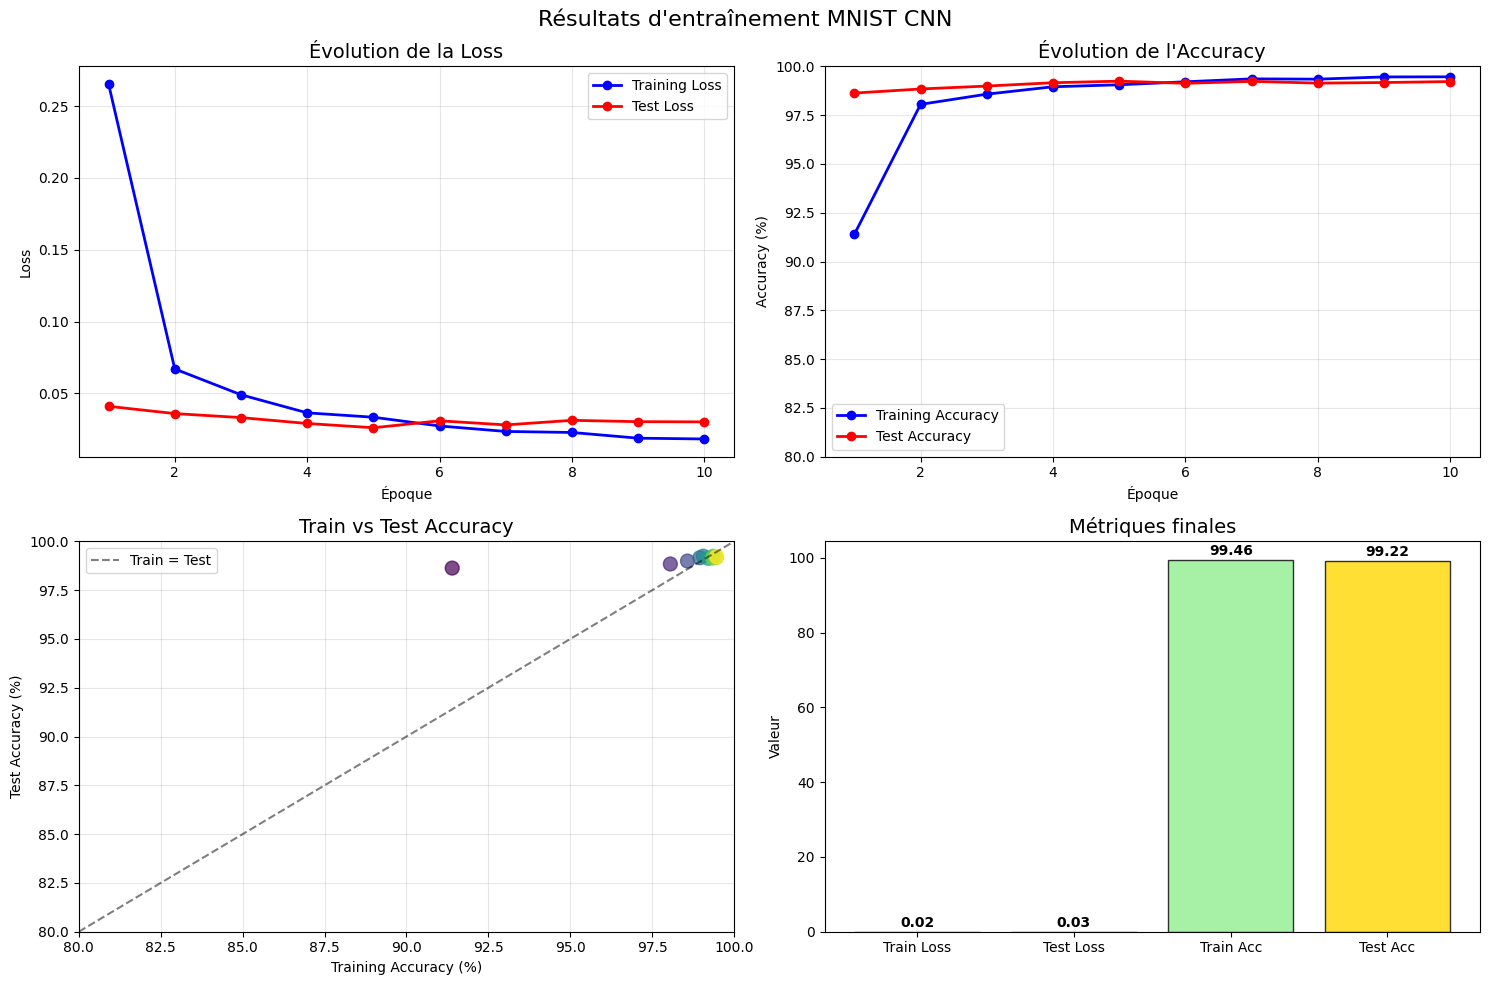

RÉSUMÉ DES PERFORMANCES:
Accuracy finale: 99.22%
Meilleure accuracy: 99.24%
Amélioration totale: 0.59% points
Loss finale: 0.0301
Écart Train-Test: 0.24% points
Pas de surapprentissage détecté
Objectif de >95% atteint!


In [19]:
# Graphiques de performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Résultats d\'entraînement MNIST CNN', fontsize=16, y=0.98)

epochs = range(1, NUM_EPOCHS + 1)

# Graphique 1: Loss d'entraînement et de test
ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
ax1.plot(epochs, test_losses, 'r-o', label='Test Loss', linewidth=2, markersize=6)
ax1.set_title('Évolution de la Loss', fontsize=14)
ax1.set_xlabel('Époque')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Accuracy d'entraînement et de test
ax2.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
ax2.plot(epochs, test_accuracies, 'r-o', label='Test Accuracy', linewidth=2, markersize=6)
ax2.set_title('Évolution de l\'Accuracy', fontsize=14)
ax2.set_xlabel('Époque')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(80, 100)

# Graphique 3: Comparaison Train vs Test Accuracy
ax3.scatter(train_accuracies, test_accuracies, c=epochs, cmap='viridis', s=100, alpha=0.7)
ax3.plot([80, 100], [80, 100], 'k--', alpha=0.5, label='Train = Test')
ax3.set_title('Train vs Test Accuracy', fontsize=14)
ax3.set_xlabel('Training Accuracy (%)')
ax3.set_ylabel('Test Accuracy (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(80, 100)
ax3.set_ylim(80, 100)

# Graphique 4: Métriques finales
metrics = ['Train Loss', 'Test Loss', 'Train Acc', 'Test Acc']
values = [train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

bars = ax4.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black')
ax4.set_title('Métriques finales', fontsize=14)
ax4.set_ylabel('Valeur')

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Résumé statistique
print("RÉSUMÉ DES PERFORMANCES:")
print("=" * 50)
print(f"Accuracy finale: {test_accuracies[-1]:.2f}%")
print(f"Meilleure accuracy: {best_accuracy:.2f}%")
print(f"Amélioration totale: {test_accuracies[-1] - test_accuracies[0]:.2f}% points")
print(f"Loss finale: {test_losses[-1]:.4f}")
print(f"Écart Train-Test: {abs(train_accuracies[-1] - test_accuracies[-1]):.2f}% points")

if abs(train_accuracies[-1] - test_accuracies[-1]) < 5:
    print("Pas de surapprentissage détecté")
else:
    print(" Possible surapprentissage")

if test_accuracies[-1] > 95:
    print("Objectif de >95% atteint!")
else:
    print(f"Objectif: atteindre >95% (actuel: {test_accuracies[-1]:.2f}%)")


In [20]:
import subprocess
import threading
import socket
from IPython.display import HTML, display
import webbrowser

def check_port_available(port):
    """Vérifie si un port est disponible"""
    try:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            return s.connect_ex(('localhost', port)) != 0
    except:
        return False

def start_web_server(port=8000):
    """Lance le serveur web depuis le dossier web (chemin correct)"""
    
    # Vérifier que le port est libre
    original_port = port
    while not check_port_available(port):
        port += 1
        if port > original_port + 10:
            print(f"Impossible de trouver un port libre (testé {original_port}-{port})")
            return None
    
    # Vérifier que le dossier web et le modèle existent
    web_dir = 'docs'
    model_file = os.path.join(web_dir, 'mnist_model.onnx')
    
    if not os.path.exists(web_dir):
        print(f"Dossier {web_dir} introuvable")
        return None
        
    if not os.path.exists(model_file):
        print(f"Modèle ONNX introuvable: {model_file}")
        print("   Exécutez d'abord la cellule d'export ONNX")
        return None
    
    def run_server():
        try:
            # Lancer le serveur depuis le dossier web
            subprocess.run(['python', '-m', 'http.server', str(port)],
                         stdout=subprocess.DEVNULL,
                         stderr=subprocess.DEVNULL,
                         cwd=web_dir)  # Exécuter depuis le dossier web
        except Exception as e:
            print(f"Erreur serveur: {e}")

    server_thread = threading.Thread(target=run_server, daemon=True)
    server_thread.start()
    time.sleep(2)

    # URLs corrigées
    local_url = f"http://localhost:{port}/"
    network_url = f"http://127.0.0.1:{port}/"

    print("Serveur web démarré avec succès!")
    print(f"Accès local: {local_url}")
    print(f"Accès réseau: {network_url}")
    
    # Créer un lien cliquable
    display(HTML(f'''
    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                padding: 20px; border-radius: 10px; text-align: center; margin: 20px 0;">
        <h2 style="color: white; margin-bottom: 15px;">Interface Web MNIST</h2>
        <a href="{local_url}" target="_blank" 
           style="background: white; color: #667eea; padding: 15px 30px; 
                  border-radius: 25px; text-decoration: none; font-weight: bold;
                  box-shadow: 0 4px 15px rgba(0,0,0,0.2); font-size: 18px;">
            Ouvrir l'Interface MNIST
        </a>
        <p style="color: white; margin-top: 15px; font-size: 14px;">
            Dessinez un chiffre et obtenez une prédiction instantanée !
        </p>
    </div>
    '''))
    
    return port

print("LANCEMENT DE L'INTERFACE WEB")
print("=" * 50)

server_port = start_web_server()

if server_port:
    print(f"Interface web active sur le port {server_port}")
else:
    print("Erreur lors du lancement de l'interface web")


LANCEMENT DE L'INTERFACE WEB
Serveur web démarré avec succès!
Accès local: http://localhost:8001/
Accès réseau: http://127.0.0.1:8001/


Interface web active sur le port 8001
